<a href="https://colab.research.google.com/github/natanrajch/subte_flow/blob/main/movimiento_pasajeros_subte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Lectura datos

In [ ]:
!pip install openpyxl --upgrade

In [ ]:
import pandas as pd

Colocar acá abajo el nombre completo del archivo que fue cargado en el Colab

In [ ]:
df = pd.read_excel("base021221.xlsx") #MODIFICAR ACÁ
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617826 entries, 0 to 617825
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   N°Tarjeta  617826 non-null  int64 
 1   Linea      617826 non-null  object
 2   Estacion   617826 non-null  object
 3   Fecha      617826 non-null  object
 4   Hora       617826 non-null  object
dtypes: int64(1), object(4)
memory usage: 23.6+ MB


Chequear que los nombres de columna y orden de las mismas sea el mismo que el del archivo a utilizar:

 0   N°Tarjeta    int64         
 1   Linea        object        
 2   Estacion     object        
 3   Fecha        datetime64

 4   Hora         object     

In [ ]:
df_info_tramos = pd.read_excel("info_tramos.xlsx") #MODIFICAR ACÁ
df_info_tramos.head()

,Tramo,Linea,Tramo_modificado_Espacio,sentido,Orden,mins_tramo,mins_desde_C1
0,Plaza de Mayo-Perú,A,Plaza de Mayo-Perú,Descendente,1,0.9667,26.5000
1,Perú-Piedras,A,Perú-Piedras,Descendente,2,1.1333,27.4667
2,Piedras-Lima,A,Piedras-Lima,Descendente,3,1.1500,28.6000
3,Lima-Sáenz Peña,A,Lima-Sáenz Peña,Descendente,4,1.1667,29.7500
4,Sáenz Peña-Congreso,A,Sáenz Peña-Congreso,Descendente,5,1.5333,30.9167


In [ ]:
df_oferta_vigente = pd.read_excel("oferta_vigente.xlsx") #MODIFICAR ACÁ. 
#CHEQUEAR QUE TODOS LOS HORARIOS SEAN TIEMPO TIME Y NO TIEMPO DATETIME. PARA ESO, NO DEBE HABER HORAS QUE PASEN LAS 00:00
df_oferta_vigente.head()

,línea,inicio,fin,intervalo,inicio_extendido,fin_extendido,formaciones_hora,usuarios_sentados_promedio_formación,m2_promedio_formación,sentados_hora,m2_parados_hora
0,A,05:30:00,06:26:00,00:07:42.857000,04:30:00,06:26:00,7.777778,180,121.0,1400.0,941.111111
1,A,06:26:00,07:22:00,00:04:54.545000,06:26:00,07:22:00,12.222222,180,121.0,2200.0,1478.888889
2,A,07:22:00,10:07:00,00:04:09.231000,07:22:00,10:07:00,14.444444,180,121.0,2600.0,1747.777778
3,A,10:07:00,15:43:00,00:05:24,10:07:00,15:43:00,11.111111,180,121.0,2000.0,1344.444444
4,A,15:43:00,19:23:00,00:04:09.231000,15:43:00,19:23:00,14.444444,180,121.0,2600.0,1747.777778


##Transformación de datos

In [ ]:
from sklearn.preprocessing import LabelEncoder
df["id"] = LabelEncoder().fit_transform(df['N°Tarjeta'])
df.drop("N°Tarjeta",axis=1,inplace=True)
df.head()

,Linea,Estacion,Fecha,Hora,id
0,Line C,Constitucion,02/12/2021,13:38:00,0
1,Line B,JMRosas,02/12/2021,07:17:00,1
2,Line B,Pellegrini,02/12/2021,14:10:00,1
3,Line C,Retiro,02/12/2021,12:11:00,2
4,Line C,Constitucion,02/12/2021,11:07:00,3


In [ ]:
#Quitar espacios de las columnas Línea y Estación
import re
df['Linea'] = df.Linea.apply(lambda l: re.sub("\s\s+" ," ", l).strip())
df['Estacion'] = df.Estacion.apply(lambda l: re.sub("\s\s+" ," ", l).strip())

In [ ]:
df["nombre_completo"] = df['Linea'] + ' ' + df['Estacion']
df.sort_values(["id","Fecha","Hora"], inplace=True)
df.head(5)

,Linea,Estacion,Fecha,Hora,id,nombre_completo
0,Line C,Constitucion,02/12/2021,13:38:00,0,Line C Constitucion
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini
3,Line C,Retiro,02/12/2021,12:11:00,2,Line C Retiro
4,Line C,Constitucion,02/12/2021,11:07:00,3,Line C Constitucion


In [ ]:
#Se convierte el campo Hora de string hacia datetime. OJO que con la primera base este paso no hizo falta. Quizás haya que agregarle un IF para tener en cuenta diefrentes bases
df['Hora'] = pd.to_datetime(df['Hora'],format= '%H:%M:%S' ).dt.time
df.head(3)

,Linea,Estacion,Fecha,Hora,id,nombre_completo
0,Line C,Constitucion,02/12/2021,13:38:00,0,Line C Constitucion
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini


In [ ]:
#Las entradas en Línea P Estación Metrovías se convierten en Línea E - Virreyes. Esto es una fuente posible de error, pero menor. Con los datos revisados, tiene más sentido tomar esto que eliminar las fichadas de Line P

df["nombre_completo"] = df.nombre_completo.replace({"Linea P METROVIAS":"Line E Virreyes"})
len(df[df.Estacion == "METROVIAS"])

3166

In [ ]:
#Modificar nombres para incorporar Combinaciones y el caso Pasco/Alberti -- "REVISAR CASO PASCO ALBERTI QUE NO ESTÁ BIEN REPRESENTADO EN EL DICT ""normalizar estaciones"" "
normalizar_combinaciones = {"Line A Lima":"Combinación A-C","Line A Miserere":"Combinación A-H","Line A Peru":"Combinación A-D-E","Line B Alem":"Combinación B-E","Line B Pellegrini":"Combinación B-C-D","Line B Pueyrredon_B":"Combinación B-H","Line C Av. de Mayo":"Combinación A-C","Line C Diagonal_Norte":"Combinación B-C-D","Line C Independencia_C":"Combinación C-E Ind","Line C Retiro":"Combinación C-E Ret","Line E Bolivar":"Combinación A-D-E","Line E Correo Central":"Combinación B-E","Line E Independencia_E":"Combinación C-E Ind","Line E Jujuy":"Combinación E-H","Line E RetiroE":"Combinación C-E Ret","Linea D 9 de Julio":"Combinación B-C-D","Linea D Catedral":"Combinación A-D-E","Linea D Pueyrredon_D":"Combinación D-H","Linea H Corrientes":"Combinación B-H","Linea H Humberto Primo":"Combinación E-H","Linea H Once":"Combinación A-H","Linea H Santa Fe":"Combinación D-H","Line A Pasco":"Line A Pasco-Alberti","Line A Alberti":"Line A Pasco-Alberti"}
df["estac_y_combins"] = df.nombre_completo.replace(normalizar_combinaciones)
print("REVISAR CASO PASCO ALBERTI QUE NO ESTÁ BIEN REPRESENTADO EN EL DICT ""normalizar combinaciones"" ","\n","\n")
df.head(2)

REVISAR CASO PASCO ALBERTI QUE NO ESTÁ BIEN REPRESENTADO EN EL DICT normalizar combinaciones  
 



,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins
0,Line C,Constitucion,02/12/2021,13:38:00,0,Line C Constitucion,Line C Constitucion
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas,Line B JMRosas


In [ ]:
#Eliminar fichadas repetidas en misma estación
fichada_repetida = ((df.estac_y_combins.shift(-1) == df.estac_y_combins) & (df.id.shift(-1)==df.id))
df["fichada_repetida"] = fichada_repetida
df_norepeat = df[~fichada_repetida]
df_norepeat

,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,fichada_repetida
0,Line C,Constitucion,02/12/2021,13:38:00,0,Line C Constitucion,Line C Constitucion,False
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas,Line B JMRosas,False
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini,Combinación B-C-D,False
3,Line C,Retiro,02/12/2021,12:11:00,2,Line C Retiro,Combinación C-E Ret,False
4,Line C,Constitucion,02/12/2021,11:07:00,3,Line C Constitucion,Line C Constitucion,False
...,...,...,...,...,...,...,...,...
617821,Line B,Gallardo,02/12/2021,21:06:00,366827,Line B Gallardo,Line B Gallardo,False
617822,Line C,Constitucion,02/12/2021,09:00:00,366828,Line C Constitucion,Line C Constitucion,False
617823,Linea D,Facultad,02/12/2021,12:04:00,366828,Linea D Facultad,Linea D Facultad,False
617824,Line A,Miserere,02/12/2021,15:42:00,366829,Line A Miserere,Combinación A-H,False


In [ ]:
df_norepeat.id.value_counts()[0]

1

In [ ]:
#Eliminar tarjetas con 1 sola transacción
conteo_fichadas = df_norepeat.id.map(df_norepeat.id.value_counts())
df2 = df_norepeat[conteo_fichadas > 1].copy() #Solo Tarjetas con al menos 2 fichadas
df2.drop("fichada_repetida", axis=1, inplace=True)
df2.head(2)


,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas,Line B JMRosas
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini,Combinación B-C-D


In [ ]:
primer_ingreso = df2.groupby("id").first().nombre_completo
df2["primer_ingreso"] = df2.id.map(primer_ingreso)
df2.head(5)

,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,primer_ingreso
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas,Line B JMRosas,Line B JMRosas
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini,Combinación B-C-D,Line B JMRosas
4,Line C,Constitucion,02/12/2021,11:07:00,3,Line C Constitucion,Line C Constitucion,Line C Constitucion
5,Line C,Av. de Mayo,02/12/2021,11:55:00,3,Line C Av. de Mayo,Combinación A-C,Line C Constitucion
6,Line B,Lacroze,02/12/2021,08:03:00,4,Line B Lacroze,Line B Lacroze,Line B Lacroze


In [ ]:
df2["origen"] = df2.nombre_completo
df2["destino"] = df2.groupby("id").nombre_completo.shift(-1)
df2.destino.fillna(df2.primer_ingreso, inplace=True)
df2.head(6)

,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B Pellegrini
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini,Combinación B-C-D,Line B JMRosas,Line B Pellegrini,Line B JMRosas
4,Line C,Constitucion,02/12/2021,11:07:00,3,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Av. de Mayo
5,Line C,Av. de Mayo,02/12/2021,11:55:00,3,Line C Av. de Mayo,Combinación A-C,Line C Constitucion,Line C Av. de Mayo,Line C Constitucion
6,Line B,Lacroze,02/12/2021,08:03:00,4,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Florida
7,Line B,Florida,02/12/2021,15:21:00,4,Line B Florida,Line B Florida,Line B Lacroze,Line B Florida,Line B Lacroze


In [ ]:
#Chequear que entre primer ingreso y último ingreso no sea la misma estación o nodo de combinación
check_vuelta_repetida = df2.origen.replace(normalizar_combinaciones) == df2.destino.replace(normalizar_combinaciones)
df3 = df2[~check_vuelta_repetida].copy()
df3.head(2)

,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B Pellegrini
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini,Combinación B-C-D,Line B JMRosas,Line B Pellegrini,Line B JMRosas


In [ ]:
df3[(df3.id>700)&(df.id<710)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino
1142,Linea D,Bulnes,02/12/2021,09:12:00,701,Linea D Bulnes,Linea D Bulnes,Linea D Bulnes,Linea D Bulnes,Linea D Catedral
1143,Linea D,Catedral,02/12/2021,19:04:00,701,Linea D Catedral,Combinación A-D-E,Linea D Bulnes,Linea D Catedral,Linea D Bulnes
1144,Line B,Tronador,02/12/2021,08:33:00,702,Line B Tronador,Line B Tronador,Line B Tronador,Line B Tronador,Line B Pueyrredon_B
1145,Line B,Pueyrredon_B,02/12/2021,12:58:00,702,Line B Pueyrredon_B,Combinación B-H,Line B Tronador,Line B Pueyrredon_B,Line B Tronador
1146,Linea D,J_Hernandez,02/12/2021,08:43:00,703,Linea D J_Hernandez,Linea D J_Hernandez,Linea D J_Hernandez,Linea D J_Hernandez,Line B Alem
1147,Line B,Alem,02/12/2021,14:11:00,703,Line B Alem,Combinación B-E,Linea D J_Hernandez,Line B Alem,Linea D J_Hernandez
1148,Line C,Retiro,02/12/2021,06:38:00,704,Line C Retiro,Combinación C-E Ret,Line C Retiro,Line C Retiro,Line C Moreno C
1149,Line C,Moreno C,02/12/2021,15:35:00,704,Line C Moreno C,Line C Moreno C,Line C Retiro,Line C Moreno C,Line C Retiro
1150,Line B,Pellegrini,02/12/2021,08:26:00,705,Line B Pellegrini,Combinación B-C-D,Line B Pellegrini,Line B Pellegrini,Line B Medrano
1151,Line B,Medrano,02/12/2021,10:14:00,705,Line B Medrano,Line B Medrano,Line B Pellegrini,Line B Medrano,Line B Pellegrini


In [ ]:
len(df), len(df2), len(df3), len(df3) / len(df)

(617826, 404104, 401302, 0.6495388669301713)

In [ ]:
normalizar_nombres = {"Line A    Acoyte              ":"Acoyte","Line A    Carabobo            ":"Carabobo","Line A    Castro Barros       ":"Castro Barros","Line A    Congreso            ":"Congreso","Line A    Flores              ":"San José de Flores","Line A    Lima                ":"Lima","Line A    Loria               ":"Loria","Line A    Miserere            ":"Plaza Miserere","Line A    Peru                ":"Perú","Line A    Plaza de Mayo       ":"Plaza de Mayo","Line A    Primera Junta       ":"Primera Junta","Line A    Puan                ":"Puán","Line A    SanPedrito          ":"San Pedrito","Line B    Alem                ":"Leandro N. Alem","Line B    Callao_B            ":"Callao B","Line B    Dorrego             ":"Dorrego","Line B    Gallardo            ":"Angel Gallardo","Line B    Gardel              ":"Carlos Gardel","Line B    JMRosas             ":"Juan Manuel de Rosas","Line B    Lacroze             ":"Federico Lacroze","Line B    Los Incas           ":"Los Incas","Line B    Malabia             ":"Malabia","Line B    Medrano             ":"Medrano","Line B    Pellegrini          ":"Carlos Pellegrini","Line B    Pueyrredon_B        ":"Pueyrredón B","Line B    Uruguay             ":"Uruguay","Line C    Av. de Mayo         ":"Avenida de Mayo","Line C    Constitucion        ":"Constitución","Line C    Diagonal_Norte      ":"Diagonal Norte","Line C    Independencia_C     ":"Independencia C","Line C    Lavalle             ":"Lavalle","Line C    Retiro              ":"Retiro C","Line C    San Martin          ":"General San Martín","Line E    Boedo               ":"Boedo","Line E    Bolivar             ":"Bolívar","Line E    Correo Central      ":"Correo Central","Line E    E Mitre             ":"Emilio Mitre","Line E    Entre Rio           ":"Entre Ríos","Line E    Independencia_E     ":"Independencia E","Line E    Jujuy               ":"Jujuy","Line E    La Plata            ":"La Plata","Line E    Milagrosa           ":"Medalla Milagrosa","Line E    Moreno              ":"José María Moreno","Line E    RetiroE             ":"Retiro E","Line E    Urquiza             ":"General Urquiza","Line E    Virreyes            ":"Plaza de los Virreyes","Linea D   9 de Julio          ":"9 de Julio","Linea D   Bulnes              ":"Bulnes","Linea D   Callao_D            ":"Callao D","Linea D   Carranza            ":"Ministro Carranza","Linea D   Catedral            ":"Catedral","Linea D   Congreso_Tuc        ":"Congreso de Tucumán","Linea D   Facultad            ":"Facultad de Medicina","Linea D   Juramento           ":"Juramento","Linea D   Olleros             ":"Olleros","Linea D   Palermo             ":"Palermo","Linea D   Plaza Italia        ":"Plaza Italia","Linea D   Pueyrredon_D        ":"Pueyrredón D","Linea D   Scalabrini Ortiz    ":"Scalabrini Ortiz","Linea D   Tribunales          ":"Tribunales","Linea H   Caseros             ":"Caseros","Linea H   Corrientes          ":"Corrientes","Linea H   FacultadDerecho     ":"Facultad de Derecho","Linea H   Hospitales          ":"Hospitales","Linea H   Humberto Primo      ":"Humberto 1","Linea H   LasHeras            ":"Las Heras","Linea H   Once                ":"Once","Linea H   Patricios           ":"Parque Patricios","Linea H   Santa Fe            ":"Santa Fe","Linea H   Venezuela           ":"Venezuela"}
# for key in normalizar_nombres:
#   print(re.sub("\s\s+" ," ", normalizar_nombres[key]).strip())

In [ ]:
normalizar_nombres = {"Line A Acoyte":"Acoyte","Line A Carabobo":"Carabobo","Line A Rio de Janeiro":"Río de Janeiro","Line A Alberti":"Pasco-Alberti","Line A Pasco":"Pasco-Alberti","Line A Castro Barros":"Castro Barros","Line A Congreso":"Congreso","Line A Flores":"San José de Flores","Line A Lima":"Lima","Line A Loria":"Loria","Line A Miserere":"Plaza Miserere","Line A Peru":"Perú","Line A Plaza de Mayo":"Plaza de Mayo","Line A Primera Junta":"Primera Junta","Line A Puan":"Puán","Line A SanPedrito":"San Pedrito","Line A Piedras":"Piedras","Line A Saenz Pena":"Sáenz Peña","Line B Alem":"Leandro N. Alem","Line B Callao_B":"Callao B","Line B Dorrego":"Dorrego","Line B Gallardo":"Angel Gallardo","Line B Echeverria":"Echeverría","Line B Gardel":"Carlos Gardel","Line B JMRosas":"Juan Manuel de Rosas","Line B Lacroze":"Federico Lacroze","Line B Los Incas":"Los Incas","Line B Malabia":"Malabia","Line B Medrano":"Medrano","Line B Pellegrini":"Carlos Pellegrini","Line B Pueyrredon_B":"Pueyrredón B","Line B Uruguay":"Uruguay","Line B Florida":"Florida","Line B Tronador":"Tronador","Line B Pasteur":"Pasteur","Line C Av. de Mayo":"Avenida de Mayo","Line C Constitucion":"Constitución","Line C Diagonal_Norte":"Diagonal Norte","Line C Independencia_C":"Independencia C","Line C Lavalle":"Lavalle","Line C Retiro":"Retiro C","Line C San Martin":"General San Martín","Line C Moreno C":"Moreno","Line C San Juan":"San Juan","Line E Boedo":"Boedo","Line E Bolivar":"Bolívar","Line E Correo Central":"Correo Central","Line E E Mitre":"Emilio Mitre","Line E Entre Rio":"Entre Ríos","Line E Independencia_E":"Independencia E","Line E Jujuy":"Jujuy","Line E La Plata":"La Plata","Line E Milagrosa":"Medalla Milagrosa","Line E Moreno":"José María Moreno","Line E RetiroE":"Retiro E","Line E Urquiza":"General Urquiza","Line E Virreyes":"Plaza de los Virreyes","Line E Varela":"Varela","Line E Pinchincha":"Pichincha","Line E San Jose":"San José","Line E Catalinas":"Catalinas","Line E Belgrano":"Belgrano","Linea D Aguero":"Agüero","Linea D 9 de Julio":"9 de Julio","Linea D Bulnes":"Bulnes","Linea D Callao_D":"Callao D","Linea D Carranza":"Ministro Carranza","Linea D Catedral":"Catedral","Linea D Congreso_Tuc":"Congreso de Tucumán","Linea D Facultad":"Facultad de Medicina","Linea D Juramento":"Juramento","Linea D Olleros":"Olleros","Linea D Palermo":"Palermo","Linea D Plaza Italia":"Plaza Italia","Linea D Pueyrredon_D":"Pueyrredón D","Linea D Scalabrini Ortiz":"Scalabrini Ortiz","Linea D J_Hernandez":"José Hernández","Linea D Tribunales":"Tribunales","Linea H Caseros":"Caseros","Linea H Corrientes":"Corrientes","Linea H FacultadDerecho":"Facultad de Derecho","Linea H Hospitales":"Hospitales","Linea H Humberto Primo":"Humberto 1","Linea H LasHeras":"Las Heras","Linea H Once":"Once","Linea H Patricios":"Parque Patricios","Linea H Santa Fe":"Santa Fe","Linea H Inclan":"Inclán","Linea H Cordoba":"Córdoba","Linea H Venezuela":"Venezuela"}

df3["origen_norm"] = df3.origen.replace(normalizar_nombres)
df3["destino_norm"] = df3.destino.replace(normalizar_nombres)
df3.head(3)

,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino,origen_norm,destino_norm
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B Pellegrini,Juan Manuel de Rosas,Carlos Pellegrini
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini,Combinación B-C-D,Line B JMRosas,Line B Pellegrini,Line B JMRosas,Carlos Pellegrini,Juan Manuel de Rosas
4,Line C,Constitucion,02/12/2021,11:07:00,3,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Av. de Mayo,Constitución,Avenida de Mayo


In [ ]:
# minute_bins = [-1,15,30,45,60]
# labels = ["00-15","16-30","31-45","46-59"]
# minute_bins = [-1,20,40,60]
# labels = ["00-20","21-39","40-59"]
# df3['Hora'] = pd.to_datetime(df3['Hora'],format= '%H:%M:%S' ).dt.time
minute_bins = [-1,30,60]
labels = ["00-30","31-59"]

df3["time_bins"] = df3.Hora.apply(lambda hora: "h:" + str(hora.hour) + ":m:") + pd.cut(df3.Hora.apply(lambda hora: hora.minute), bins=minute_bins, labels=labels).astype(str)
df3.head()

,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino,origen_norm,destino_norm,time_bins
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B Pellegrini,Juan Manuel de Rosas,Carlos Pellegrini,h:7:m:00-30
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini,Combinación B-C-D,Line B JMRosas,Line B Pellegrini,Line B JMRosas,Carlos Pellegrini,Juan Manuel de Rosas,h:14:m:00-30
4,Line C,Constitucion,02/12/2021,11:07:00,3,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Av. de Mayo,Constitución,Avenida de Mayo,h:11:m:00-30
5,Line C,Av. de Mayo,02/12/2021,11:55:00,3,Line C Av. de Mayo,Combinación A-C,Line C Constitucion,Line C Av. de Mayo,Line C Constitucion,Avenida de Mayo,Constitución,h:11:m:31-59
6,Line B,Lacroze,02/12/2021,08:03:00,4,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Florida,Federico Lacroze,Florida,h:8:m:00-30


In [ ]:
#Chequear si todas las estaciones+time bins de df1 existen en df3
df["time_bins"] = df.Hora.apply(lambda hora: "h:" + str(hora.hour) + ":m:") + pd.cut(df.Hora.apply(lambda hora: hora.minute), bins=minute_bins, labels=labels).astype(str)

validaciones_estacion_timebin_df1 = df.groupby(["nombre_completo","time_bins"]).nombre_completo.count()
validaciones_estacion_timebin_df3 = df3.groupby(["nombre_completo","time_bins"]).nombre_completo.count()

estaciones_time_bins = df3.groupby(["nombre_completo","time_bins"]).destino.count().index
total = 0
for bin in df.groupby(["nombre_completo","time_bins"]).nombre_completo.count().index:
  if bin not in estaciones_time_bins:
    print(bin, validaciones_estacion_timebin_df1[bin])
    total += validaciones_estacion_timebin_df1[bin]
print("Casos no registrados:",total) 
#('Line A    Acoyte              ', 'h:10:m:00-14') in df3.groupby(["nombre_completo","time_bins"]).destino.count().index
#list(df3.groupby(["nombre_completo","time_bins","destino"]).destino.count().index[0])[:2]

('Line A Congreso', 'h:5:m:00-30') 3
('Line B Dorrego', 'h:5:m:00-30') 1
('Line B Florida', 'h:5:m:31-59') 3
('Line B Gallardo', 'h:5:m:00-30') 3
('Line B Tronador', 'h:5:m:00-30') 1
('Line B Uruguay', 'h:23:m:31-59') 2
('Line C Av. de Mayo', 'h:5:m:00-30') 2
('Line C Diagonal_Norte', 'h:23:m:00-30') 1
('Line C San Juan', 'h:5:m:00-30') 1
('Line E Belgrano', 'h:5:m:00-30') 3
('Line E Boedo', 'h:23:m:00-30') 1
('Line E Boedo', 'h:5:m:31-59') 2
('Line E Catalinas', 'h:5:m:31-59') 1
('Line E Catalinas', 'h:6:m:31-59') 3
('Line E Entre Rio', 'h:23:m:00-30') 1
('Line E Independencia_E', 'h:5:m:00-30') 1
('Line E La Plata', 'h:5:m:00-30') 1
('Line E Milagrosa', 'h:22:m:31-59') 1
('Line E Moreno', 'h:23:m:00-30') 1
('Line E Pinchincha', 'h:23:m:00-30') 2
('Line E Pinchincha', 'h:5:m:31-59') 1
('Line E Varela', 'h:23:m:31-59') 1
('Linea D 9 de Julio', 'h:23:m:00-30') 1
('Linea D Catedral', 'h:5:m:00-30') 1
('Linea D Plaza Italia', 'h:23:m:31-59') 1
('Linea D Pueyrredon_D', 'h:5:m:31-59') 3
('L

In [ ]:
#Crear en df3 una columna con el proporcional de la validación conocida con origen destino al total de validaciones en df
#validaciones_estacion_timebin_destino_df3 = df3.groupby(["nombre_completo","time_bins","destino"]).nombre_completo.count()

df3["validaciones"] = df3.apply(lambda row: validaciones_estacion_timebin_df1[(row.nombre_completo, row.time_bins)] / validaciones_estacion_timebin_df3[(row.nombre_completo, row.time_bins)], axis=1 )
df3.head()


,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,primer_ingreso,origen,destino,origen_norm,destino_norm,time_bins,validaciones
1,Line B,JMRosas,02/12/2021,07:17:00,1,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B JMRosas,Line B Pellegrini,Juan Manuel de Rosas,Carlos Pellegrini,h:7:m:00-30,1.264256
2,Line B,Pellegrini,02/12/2021,14:10:00,1,Line B Pellegrini,Combinación B-C-D,Line B JMRosas,Line B Pellegrini,Line B JMRosas,Carlos Pellegrini,Juan Manuel de Rosas,h:14:m:00-30,1.540816
4,Line C,Constitucion,02/12/2021,11:07:00,3,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Constitucion,Line C Av. de Mayo,Constitución,Avenida de Mayo,h:11:m:00-30,1.680124
5,Line C,Av. de Mayo,02/12/2021,11:55:00,3,Line C Av. de Mayo,Combinación A-C,Line C Constitucion,Line C Av. de Mayo,Line C Constitucion,Avenida de Mayo,Constitución,h:11:m:31-59,1.728814
6,Line B,Lacroze,02/12/2021,08:03:00,4,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Lacroze,Line B Florida,Federico Lacroze,Florida,h:8:m:00-30,1.280683


In [ ]:
len(df) - sum(df3.validaciones), len(df3)

(46.00000010896474, 401302)

##Cálculo Shortest Path

Edge Data from Subte GTFS
Linea E times between stations simplified into only one value (I guess it was some data noise in original gtfs)
Pasco y Alberti joined into one station
Correo Central, Catalinas and Retiro E manually added to gtfs data


In [ ]:
import networkx as nx

In [ ]:
nodes = ["Plaza de Mayo","Perú","Piedras","Lima","Sáenz Peña","Congreso","Pasco-Alberti","Plaza Miserere","Loria","Castro Barros","Río de Janeiro","Acoyte","Primera Junta","Puán","Carabobo","San José de Flores","San Pedrito","Leandro N. Alem","Florida","Carlos Pellegrini","Uruguay","Callao B","Pasteur","Pueyrredón B","Carlos Gardel","Medrano","Angel Gallardo","Malabia","Dorrego","Federico Lacroze","Tronador","Los Incas","Echeverría","Juan Manuel de Rosas","Retiro C","General San Martín","Lavalle","Diagonal Norte","Avenida de Mayo","Moreno","Independencia C","San Juan","Constitución","Catedral","9 de Julio","Tribunales","Callao D","Facultad de Medicina","Pueyrredón D","Agüero","Bulnes","Scalabrini Ortiz","Plaza Italia","Palermo","Ministro Carranza","Olleros","José Hernández","Juramento","Congreso de Tucumán","Retiro E","Catalinas","Correo Central","Bolívar","Belgrano","Independencia E","San José","Entre Ríos","Pichincha","Jujuy","General Urquiza","Boedo","La Plata","José María Moreno","Emilio Mitre","Medalla Milagrosa","Varela","Plaza de los Virreyes","Facultad de Derecho","Las Heras","Santa Fe","Córdoba","Corrientes","Once","Venezuela","Humberto 1","Inclán","Caseros","Parque Patricios","Hospitales"]

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(nodes)

In [ ]:
edges = [["9 de Julio","Carlos Pellegrini",3.1000],["9 de Julio","Diagonal Norte",5.4000],["Avenida de Mayo","Lima",3.1000],["Bolívar","Catedral",5.4000],["Bolívar","Perú",3.4000],["Carlos Pellegrini","9 de Julio",3.1000],["Carlos Pellegrini","Diagonal Norte",6.0000],["Catedral","Bolívar",5.4000],["Catedral","Perú",3.1000],["Corrientes","Pueyrredón B",3.1000],["Diagonal Norte","9 de Julio",5.4000],["Diagonal Norte","Carlos Pellegrini",6.0000],["Humberto 1","Jujuy",3.1000],["Independencia C","Independencia E",3.7000],["Independencia E","Independencia C",3.7000],["Jujuy","Humberto 1",3.1000],["Lima","Avenida de Mayo",3.1000],["Once","Plaza Miserere",3.1000],["Perú","Bolívar",3.4000],["Perú","Catedral",3.1000],["Plaza Miserere","Once",3.1000],["Pueyrredón B","Corrientes",3.1000],["Pueyrredón D","Santa Fe",3.1000],["Santa Fe","Pueyrredón D",3.1000],["Acoyte","Primera Junta",1.5500],["Acoyte","Río de Janeiro",1.7833],["Pasco-Alberti","Plaza Miserere",1.5833],["Carabobo","Puán",1.8833],["Carabobo","San José de Flores",1.9333],["Castro Barros","Loria",1.6500],["Castro Barros","Río de Janeiro",2.0000],["Congreso","Pasco-Alberti",1.5833],["Congreso","Sáenz Peña",1.5333],["Lima","Piedras",1.1500],["Lima","Sáenz Peña",1.1667],["Loria","Castro Barros",1.6500],["Loria","Plaza Miserere",2.2833],["Pasco-Alberti","Congreso",1.5833],["Perú","Piedras",1.1333],["Perú","Plaza de Mayo",0.9667],["Piedras","Lima",1.1500],["Piedras","Perú",1.1333],["Plaza de Mayo","Perú",0.9667],["Plaza Miserere","Loria",2.2833],["Plaza Miserere","Pasco-Alberti",1.5833],["Primera Junta","Acoyte",1.5500],["Primera Junta","Puán",1.9333],["Puán","Carabobo",1.8833],["Puán","Primera Junta",1.9333],["Río de Janeiro","Acoyte",1.7833],["Río de Janeiro","Castro Barros",2.0000],["Sáenz Peña","Congreso",1.5333],["Sáenz Peña","Lima",1.1667],["San José de Flores","Carabobo",1.9333],["San José de Flores","San Pedrito",1.7500],["San Pedrito","San José de Flores",1.7500],["Angel Gallardo","Malabia",1.9333],["Angel Gallardo","Medrano",1.9500],["Callao B","Pasteur",1.4333],["Callao B","Uruguay",1.3167],["Carlos Gardel","Medrano",1.9500],["Carlos Gardel","Pueyrredón B",1.4667],["Carlos Pellegrini","Florida",1.4833],["Carlos Pellegrini","Uruguay",1.3167],["Dorrego","Federico Lacroze",1.7167],["Dorrego","Malabia",2.3000],["Echeverría","Juan Manuel de Rosas",1.6167],["Echeverría","Los Incas",1.9167],["Federico Lacroze","Dorrego",1.7167],["Federico Lacroze","Tronador",2.3500],["Florida","Carlos Pellegrini",1.4833],["Florida","Leandro N. Alem",1.1167],["Juan Manuel de Rosas","Echeverría",1.6167],["Leandro N. Alem","Florida",1.1167],["Los Incas","Echeverría",1.9167],["Los Incas","Tronador",1.6500],["Malabia","Angel Gallardo",1.9333],["Malabia","Dorrego",2.3000],["Medrano","Angel Gallardo",1.9500],["Medrano","Carlos Gardel",1.9500],["Pasteur","Callao B",1.4333],["Pasteur","Pueyrredón B",1.3333],["Pueyrredón B","Carlos Gardel",1.4667],["Pueyrredón B","Pasteur",1.3333],["Tronador","Federico Lacroze",2.3500],["Tronador","Los Incas",1.6500],["Uruguay","Callao B",1.3167],["Uruguay","Carlos Pellegrini",1.3167],["Avenida de Mayo","Diagonal Norte",1.6667],["Avenida de Mayo","Moreno",1.3000],["Constitución","San Juan",1.6500],["Diagonal Norte","Avenida de Mayo",1.6667],["Diagonal Norte","Lavalle",1.3500],["General San Martín","Lavalle",2.2500],["General San Martín","Retiro C",1.3000],["Independencia C","Moreno",1.8167],["Independencia C","San Juan",1.5833],["Lavalle","Diagonal Norte",1.3500],["Lavalle","General San Martín",2.2500],["Moreno","Avenida de Mayo",1.3000],["Moreno","Independencia C",1.8167],["Retiro C","General San Martín",1.3000],["San Juan","Constitución",1.6500],["San Juan","Independencia C",1.5833],["9 de Julio","Catedral",1.6833],["9 de Julio","Tribunales",1.3167],["Agüero","Bulnes",1.4333],["Agüero","Pueyrredón D",1.4000],["Bulnes","Agüero",1.4333],["Bulnes","Scalabrini Ortiz",1.4500],["Callao D","Facultad de Medicina",1.3000],["Callao D","Tribunales",1.9833],["Catedral","9 de Julio",1.6833],["Congreso de Tucumán","Juramento",2.1500],["Facultad de Medicina","Callao D",1.3000],["Facultad de Medicina","Pueyrredón D",2.0000],["José Hernández","Juramento",1.5167],["José Hernández","Olleros",2.0000],["Juramento","Congreso de Tucumán",2.1500],["Juramento","José Hernández",1.5167],["Ministro Carranza","Olleros",2.4167],["Ministro Carranza","Palermo",2.1333],["Olleros","José Hernández",2.0000],["Olleros","Ministro Carranza",2.4167],["Palermo","Ministro Carranza",2.1333],["Palermo","Plaza Italia",1.5000],["Plaza Italia","Palermo",1.5000],["Plaza Italia","Scalabrini Ortiz",1.5667],["Pueyrredón D","Agüero",1.4000],["Pueyrredón D","Facultad de Medicina",2.0000],["Scalabrini Ortiz","Bulnes",1.4500],["Scalabrini Ortiz","Plaza Italia",1.5667],["Tribunales","9 de Julio",1.3167],["Tribunales","Callao D",1.9833],["Belgrano","Bolívar",1.5000],["Belgrano","Independencia E",1.5333],["Boedo","General Urquiza",1.6500],["Boedo","La Plata",2.0167],["Bolívar","Belgrano",1.5000],["Emilio Mitre","José María Moreno",2.1167],["Emilio Mitre","Medalla Milagrosa",2.1500],["Entre Ríos","Pichincha",1.3833],["Entre Ríos","San José",1.5000],["General Urquiza","Boedo",1.6500],["General Urquiza","Jujuy",1.6000],["Independencia E","Belgrano",1.5333],["Independencia E","San José",1.8000],["José María Moreno","Emilio Mitre",2.1167],["José María Moreno","La Plata",1.9333],["Jujuy","General Urquiza",1.6000],["Jujuy","Pichincha",1.4000],["La Plata","Boedo",2.0167],["La Plata","José María Moreno",1.9333],["Medalla Milagrosa","Emilio Mitre",2.1500],["Medalla Milagrosa","Varela",1.9500],["Pichincha","Entre Ríos",1.3833],["Pichincha","Jujuy",1.4000],["Plaza de los Virreyes","Varela",1.3333],["San José","Entre Ríos",1.5000],["San José","Independencia E",1.8000],["Varela","Medalla Milagrosa",1.9500],["Varela","Plaza de los Virreyes",1.3333],["Caseros","Inclán",1.6667],["Caseros","Parque Patricios",2.0167],["Córdoba","Corrientes",1.5000],["Córdoba","Santa Fe",1.2167],["Corrientes","Córdoba",1.5000],["Corrientes","Once",1.5000],["Facultad de Derecho","Las Heras",1.6500],["Hospitales","Parque Patricios",1.8667],["Humberto 1","Inclán",1.7000],["Humberto 1","Venezuela",2.0833],["Inclán","Caseros",1.6667],["Inclán","Humberto 1",1.7000],["Las Heras","Facultad de Derecho",1.6500],["Las Heras","Santa Fe",2.0667],["Once","Corrientes",1.5000],["Once","Venezuela",1.6667],["Parque Patricios","Caseros",2.0167],["Parque Patricios","Hospitales",1.8667],["Santa Fe","Córdoba",1.2167],["Santa Fe","Las Heras",2.0667],["Venezuela","Humberto 1",2.0833],["Venezuela","Once",1.6667],["Bolívar","Correo Central",2.3739],["Correo Central","Bolívar",2.3739],["Catalinas","Correo Central",2.0391],["Correo Central","Catalinas",2.0391],["Retiro E","Catalinas",1.6961],["Catalinas","Retiro E",1.6961],["Retiro E","Retiro C",3.1000],["Retiro C","Retiro E",3.1000],["Correo Central","Leandro N. Alem",3.1000],["Leandro N. Alem","Correo Central",3.1000]]
for edge in edges:
  u,v,weight=edge
  G.add_edge(u, v, weight=weight)

In [ ]:
shortest_paths = {}
for node in nodes:
  shortest_paths[node] = nx.shortest_path(G,source=node, weight="weight")


In [ ]:
from collections import defaultdict
edges_weights = defaultdict(dict)
for edge in edges:
  u,v,weight=edge
  edges_weights[u][v] = weight

## Combinación Datos Molinetes con Shortest Path para crear un df de movimientos en el Subte

In [ ]:
from datetime import timedelta
from datetime import datetime
from datetime import date


tramos = []
horas = []
validaciones = []
sube_baja = []
origenes=[]
destinos=[]
for row in df3.itertuples():
  path = shortest_paths[row.origen_norm][row.destino_norm]
  mins_acum = 0
  for i in range(len(path)-1):
    origen = path[i]
    destino = path[i+1]
    tramos.append(origen + "-" + destino)
    horas.append((datetime.combine(date(100,1,1),row.Hora) + timedelta(minutes=mins_acum)).time())
    validaciones.append(row.validaciones)
    if i == 0:
      sube_baja.append("sube")
    elif i == (len(path) - 2):
      sube_baja.append("baja")
    else:
      sube_baja.append("-")
    origenes.append(origen)
    destinos.append(destino)
    mins_acum += edges_weights[origen][destino]

In [ ]:
  len(tramos), len(horas), len(validaciones), len(sube_baja), len(origenes), len(destinos)

(3753061, 3753061, 3753061, 3753061, 3753061, 3753061)

To DO (CREO que ya esta hecho? pero no tomando de franquiciados): convertir los datos obtenidos para una porción de los fichajes en el total de fichajes. Idea: Tomar tarjetas con destino conocido cada 20 min de cada estación en todo el horario. Considerar el % que va a cada destino. Luego tomar el total de tarjetas en esos 20 min, y multiplicar proporcionalmente.
El total de tarjetas se puede realizar con los datos de molinetes, aunque sería bueno tomar la otra base que incluye también a los franquiciados.

In [ ]:
cargadf = pd.DataFrame(list(zip(tramos, horas, validaciones,sube_baja, origenes, destinos)),
               columns =['tramos', 'horas','pasajeros','sube_baja', 'origen', 'destino'])
cargadf.head(20)

,tramos,horas,pasajeros,sube_baja,origen,destino
0,Juan Manuel de Rosas-Echeverría,07:17:00,1.264256,sube,Juan Manuel de Rosas,Echeverría
1,Echeverría-Los Incas,07:18:37.002000,1.264256,-,Echeverría,Los Incas
2,Los Incas-Tronador,07:20:32.004000,1.264256,-,Los Incas,Tronador
3,Tronador-Federico Lacroze,07:22:11.004000,1.264256,-,Tronador,Federico Lacroze
4,Federico Lacroze-Dorrego,07:24:32.004000,1.264256,-,Federico Lacroze,Dorrego
5,Dorrego-Malabia,07:26:15.006000,1.264256,-,Dorrego,Malabia
6,Malabia-Angel Gallardo,07:28:33.006000,1.264256,-,Malabia,Angel Gallardo
7,Angel Gallardo-Medrano,07:30:29.004000,1.264256,-,Angel Gallardo,Medrano
8,Medrano-Carlos Gardel,07:32:26.004000,1.264256,-,Medrano,Carlos Gardel
9,Carlos Gardel-Pueyrredón B,07:34:23.004000,1.264256,-,Carlos Gardel,Pueyrredón B


In [ ]:
#Chequeo que los tramos en el df de info tramos sean únicos
print('Tramo_modificado_Espacio es único:', df_info_tramos.Tramo_modificado_Espacio.is_unique)

#Genero un DICT con la info de los tramos para más velocidad de acceso a los datos
info_tramos_dict = defaultdict(dict)
for row in df_info_tramos.itertuples():
  info_tramos_dict[row.Tramo_modificado_Espacio]['linea'] = row.Linea
  info_tramos_dict[row.Tramo_modificado_Espacio]['sentido'] = row.sentido
  info_tramos_dict[row.Tramo_modificado_Espacio]['mins_desde_C1'] = row.mins_desde_C1


Tramo_modificado_Espacio es único: True


In [ ]:
cargadf = cargadf.merge(df_info_tramos,how='left', left_on='tramos', right_on='Tramo_modificado_Espacio').drop(['Tramo','Tramo_modificado_Espacio'], axis=1)
cargadf.head(2)

,tramos,horas,pasajeros,sube_baja,origen,destino,Linea,sentido,Orden,mins_tramo,mins_desde_C1
0,Juan Manuel de Rosas-Echeverría,07:17:00,1.264256,sube,Juan Manuel de Rosas,Echeverría,B,Ascendente,16.0,1.6167,0.0000
1,Echeverría-Los Incas,07:18:37.002000,1.264256,-,Echeverría,Los Incas,B,Ascendente,15.0,1.9167,1.6167


In [ ]:
bins = [-1,10,20,30,40,50,60]
labels= [i for i in range(len(bins)-1)]
labels_text= ['{0:0>2}'.format(str(bins[i]+1))+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
cargadf["time_bin_num"] = cargadf.horas.apply(lambda hora: hora.hour * 10) + pd.cut(cargadf.horas.apply(lambda hora: hora.minute),bins=bins, labels=labels).astype(int)
cargadf["time_bin"] = cargadf.horas.apply(lambda hora: '{0:0>2}'.format(str(hora.hour))+":") + pd.cut(cargadf.horas.apply(lambda hora: hora.minute),bins=bins, labels=labels_text).astype(str)
cargadf.head(5)

,tramos,horas,pasajeros,sube_baja,origen,destino,Linea,sentido,Orden,mins_tramo,mins_desde_C1,time_bin_num,time_bin
0,Juan Manuel de Rosas-Echeverría,07:17:00,1.264256,sube,Juan Manuel de Rosas,Echeverría,B,Ascendente,16.0,1.6167,0.0000,71,07:11-20
1,Echeverría-Los Incas,07:18:37.002000,1.264256,-,Echeverría,Los Incas,B,Ascendente,15.0,1.9167,1.6167,71,07:11-20
2,Los Incas-Tronador,07:20:32.004000,1.264256,-,Los Incas,Tronador,B,Ascendente,14.0,1.6500,3.5334,71,07:11-20
3,Tronador-Federico Lacroze,07:22:11.004000,1.264256,-,Tronador,Federico Lacroze,B,Ascendente,13.0,2.3500,5.1834,72,07:21-30
4,Federico Lacroze-Dorrego,07:24:32.004000,1.264256,-,Federico Lacroze,Dorrego,B,Ascendente,12.0,1.7167,7.5334,72,07:21-30


In [ ]:
pasajeros_hora_df = cargadf.groupby(['tramos','time_bin_num']).agg('sum').reset_index().merge(df_info_tramos[['Tramo_modificado_Espacio','Linea','mins_desde_C1']],how='left', left_on='tramos', right_on='Tramo_modificado_Espacio').drop(['Tramo_modificado_Espacio'], axis=1)
pasajeros_hora_df.fillna('Combinación', inplace=True)
pasajeros_hora_df['pasajeros_hora'] = pasajeros_hora_df.pasajeros * 6
pasajeros_hora_df.tail(2)

,tramos,time_bin_num,pasajeros,Orden,mins_tramo,mins_desde_C1_x,Linea,mins_desde_C1_y,pasajeros_hora
21040,Venezuela-Once,233,6.2,30.0,8.3335,149.6670,H,29.9334,37.2
21041,Venezuela-Once,235,5.0,12.0,3.3334,59.8668,H,29.9334,30.0


In [ ]:
pasajeros_hora_df.columns

Index(['tramos', 'time_bin_num', 'pasajeros', 'Orden', 'mins_tramo',
       'mins_desde_C1_x', 'Linea', 'mins_desde_C1_y', 'pasajeros_hora'],
      dtype='object')

##Oferta y Ocupacion

In [ ]:
ocupacion_hora_df = pasajeros_hora_df.copy()

In [ ]:
ocupacion_hora_df.mins_desde_C1_y.unique()

array(['Combinación', 24.1667, 30.683300000000003, 43.333200000000005,
       9.049900000000001, 38.6833, 16.166700000000002, 44.3667, 13.4834,
       6.35, 20.5667, 22.366600000000002, 39.6091, 11.499999999999998,
       50.4757, 38.1091, 23.866600000000002, 14.733400000000001,
       40.116600000000005, 36.2334, 21.6167, 33.9833, 20.866699999999998,
       3.6833, 48.699799999999996, 40.4667, 17.383399999999998, 24.2501,
       33.6, 35.383399999999995, 15.050099999999999, 12.833200000000001,
       39.5499, 33.6961, 28.2796, 29.000000000000004, 0.0, 32.45, 19.9331,
       35.7352, 26.2405, 26.9334, 6.4334, 4.9334, 25.7167, 18.9, 8.0167,
       48.6, 9.2501, 56.2334, 1.6167, 5.433299999999999, 56.5424, 44.4424,
       17.5333, 19.566699999999997, 35.283300000000004, 7.5334, 50.3167,
       32.1167, 25.7334, 15.3, 11.6167, 48.8257, 13.149999999999999,
       39.0668, 11.683399999999999, 31.600099999999998,
       13.383399999999998, 33.6834, 3.2333, 23.6834, 20.8333, 41.1424,
       5

In [ ]:
from datetime import time
def calc_oferta_hora(row,tipo):
  hora_bin = int((row.time_bin_num - (row.time_bin_num % 10)) /10) #obtener hora
  minutos_bin = row.time_bin_num % 10 *10 + 5 #Obtener los minutos (se toma tramo intermedio del bin, es decir, a los +5 minutos de bins de 10 min)
  if row.mins_desde_C1_y == 'Combinación':
    mins_desde_C1 = 0
  else:
    mins_desde_C1 = row.mins_desde_C1_y

  #Se eleva el hora_bin a datetime para poder restarle los mins desde C1
  tiempo = (datetime.combine(date(1988,1,1),time(hora_bin,minutos_bin,0)) - timedelta(minutes=mins_desde_C1)).time()
  oferta_hora = df_oferta_vigente[(df_oferta_vigente['inicio_extendido'] < tiempo) & 
                           (df_oferta_vigente['fin_extendido'] >= tiempo) &
                           (df_oferta_vigente['línea'] == row.Linea)][tipo].values
  if oferta_hora.size > 0:
    return oferta_hora[0]
  return 0


In [ ]:
ocupacion_hora_df['sentados_hora'] = ocupacion_hora_df.apply(lambda row: calc_oferta_hora(row,'sentados_hora'), axis=1)
ocupacion_hora_df['m2_parados_hora'] = ocupacion_hora_df.apply(lambda row: calc_oferta_hora(row,'m2_parados_hora'), axis=1)
ocupacion_hora_df.tail(3)

,tramos,time_bin_num,pasajeros,Orden,mins_tramo,mins_desde_C1_x,Linea,mins_desde_C1_y,pasajeros_hora,sentados_hora,m2_parados_hora
21039,Venezuela-Once,232,4.7,24.0,6.6668,119.7336,H,29.9334,28.2,1701.818182,1167.545455
21040,Venezuela-Once,233,6.2,30.0,8.3335,149.6670,H,29.9334,37.2,1701.818182,1167.545455
21041,Venezuela-Once,235,5.0,12.0,3.3334,59.8668,H,29.9334,30.0,1701.818182,1167.545455


In [ ]:
ocupacion_hora_df[ocupacion_hora_df.tramos == '9 de Julio-Catedral'].ocupación_pas_x_m2.unique()

array([0.0], dtype=object)

In [ ]:
ocupacion_hora_df[(ocupacion_hora_df.Linea == 'B')].m2_parados_hora.unique()

array([1184.51612903, 1776.77419355, 2072.90322581, 1628.70967742,
       2072.90322581, 1480.64516129])

In [ ]:
#Cálculo de OCUPACIÓN
def calc_ocupacion(row):
  if row.m2_parados_hora > 0:
    return max([0, row.pasajeros_hora - row.sentados_hora])/row.m2_parados_hora
  return "-"
ocupacion_hora_df['ocupación_pas_x_m2'] = ocupacion_hora_df.apply(calc_ocupacion,axis=1)
#Se quitan los tramos de combinación para el cálculo de la ocupación máxima por tramo
ocupacion_hora_df = ocupacion_hora_df[ocupacion_hora_df.Linea != 'Combinación'].copy()
ocupacion_hora_df.tail(5)

,tramos,time_bin_num,pasajeros,Orden,mins_tramo,mins_desde_C1_x,Linea,mins_desde_C1_y,pasajeros_hora,sentados_hora,m2_parados_hora,ocupación_pas_x_m2
21037,Venezuela-Once,230,23.735714,84.0,23.3338,419.0676,H,29.9334,142.414286,1701.818182,1167.545455,0.0
21038,Venezuela-Once,231,8.300000,30.0,8.3335,149.6670,H,29.9334,49.800000,1701.818182,1167.545455,0.0
21039,Venezuela-Once,232,4.700000,24.0,6.6668,119.7336,H,29.9334,28.200000,1701.818182,1167.545455,0.0
21040,Venezuela-Once,233,6.200000,30.0,8.3335,149.6670,H,29.9334,37.200000,1701.818182,1167.545455,0.0
21041,Venezuela-Once,235,5.000000,12.0,3.3334,59.8668,H,29.9334,30.000000,1701.818182,1167.545455,0.0


In [ ]:
tramos_cargas_timebin_df = pd.pivot_table(cargadf, values="pasajeros", columns="time_bin", index="tramos", aggfunc="sum").fillna(0) * 6
tramos_cargas_timebin_df.head(2)

time_bin,00:00-10,05:11-20,05:21-30,05:31-40,05:41-50,05:51-60,06:00-10,06:11-20,06:21-30,06:31-40,...,22:21-30,22:31-40,22:41-50,22:51-60,23:00-10,23:11-20,23:21-30,23:31-40,23:41-50,23:51-60
tramos,,,,,,,,,,,,,,,,,,,,,
9 de Julio-Carlos Pellegrini,0.0,0.0,0.0,0.0,19.050000,0.00000,7.615385,90.191234,74.092144,111.930466,...,45.363275,50.586709,79.455515,55.291906,97.735960,45.327273,8.666667,0.0,0.0,0.0
9 de Julio-Catedral,0.0,0.0,0.0,0.0,35.428571,49.67027,90.595270,182.619456,162.669498,214.849776,...,100.404958,85.030610,102.370636,45.512175,110.891613,78.123810,19.400000,0.0,0.0,0.0


#Resultados

##JSON para visualización

In [ ]:
print('Chequeo de que el df ocupacion_hora_df tiene únicamente 1 row por cada timebin-tramo: ')
ocupacion_hora_df.groupby(['time_bin_num','tramos'])['pasajeros'].count().values.max() == 1

Chequeo de que el df ocupacion_hora_df tiene únicamente 1 row por cada timebin-tramo: 


True

In [ ]:
#ARMADO DE UN DICT PARA DUMPEAR A UN JSON
viz_dict = {}
for timebin in ocupacion_hora_df.time_bin_num.unique():
  viz_dict[str(timebin)] = {tramo: {'pasajeros_hora':0,'ocupacion_pas_x_m2':0} for tramo in ocupacion_hora_df.tramos.unique()}

for row in ocupacion_hora_df.itertuples():
  viz_dict[str(row.time_bin_num)][row.tramos]['pasajeros_hora'] = row.pasajeros_hora
  viz_dict[str(row.time_bin_num)][row.tramos]['ocupacion_pas_x_m2'] = row.ocupación_pas_x_m2

In [ ]:
import json
#Dumpeo a un json
# json_object = json.dumps(viz_dict, indent = 4, ensure_ascii=False, sort_keys=True) 
with open("viz_data.json", "w") as outfile:
    json.dump(viz_dict, outfile, indent = 4, ensure_ascii=False)

##Datos para gráficos

In [ ]:
#DEVOLVER POR LINEA Y TIME_BIN EL VALOR DE MAXIMA CARGA DE PASAJEROS/HORA
maximas_cargas = pasajeros_hora_df.loc[pasajeros_hora_df[['Linea','time_bin_num','pasajeros_hora']].groupby(['Linea','time_bin_num'])['pasajeros_hora'].idxmax()][['Linea','time_bin_num','pasajeros_hora','tramos']].copy()
maximas_cargas.to_excel('maximas_cargas.xlsx')

In [ ]:
ocupacion_hora_df[['Linea','time_bin_num','ocupación_pas_x_m2']].groupby(['Linea','time_bin_num'])['ocupación_pas_x_m2'].agg('max')

Linea  time_bin_num
A      0               0.0
       52              0.0
       53              0.0
       54              0.0
       55              0.0
                      ... 
H      231             0.0
       232             0.0
       233             0.0
       234             0.0
       235             0.0
Name: ocupación_pas_x_m2, Length: 675, dtype: float64

In [ ]:
maximas_ocupaciones = ocupacion_hora_df.loc[ocupacion_hora_df[['Linea','time_bin_num','ocupación_pas_x_m2']].groupby(['Linea','time_bin_num'])['ocupación_pas_x_m2'].idxmax()][['Linea','time_bin_num','ocupación_pas_x_m2','tramos']].copy()
maximas_ocupaciones.to_excel('maximas_ocupaciones.xlsx')

TypeError: ignored

##Gráficos Máximas Cargas

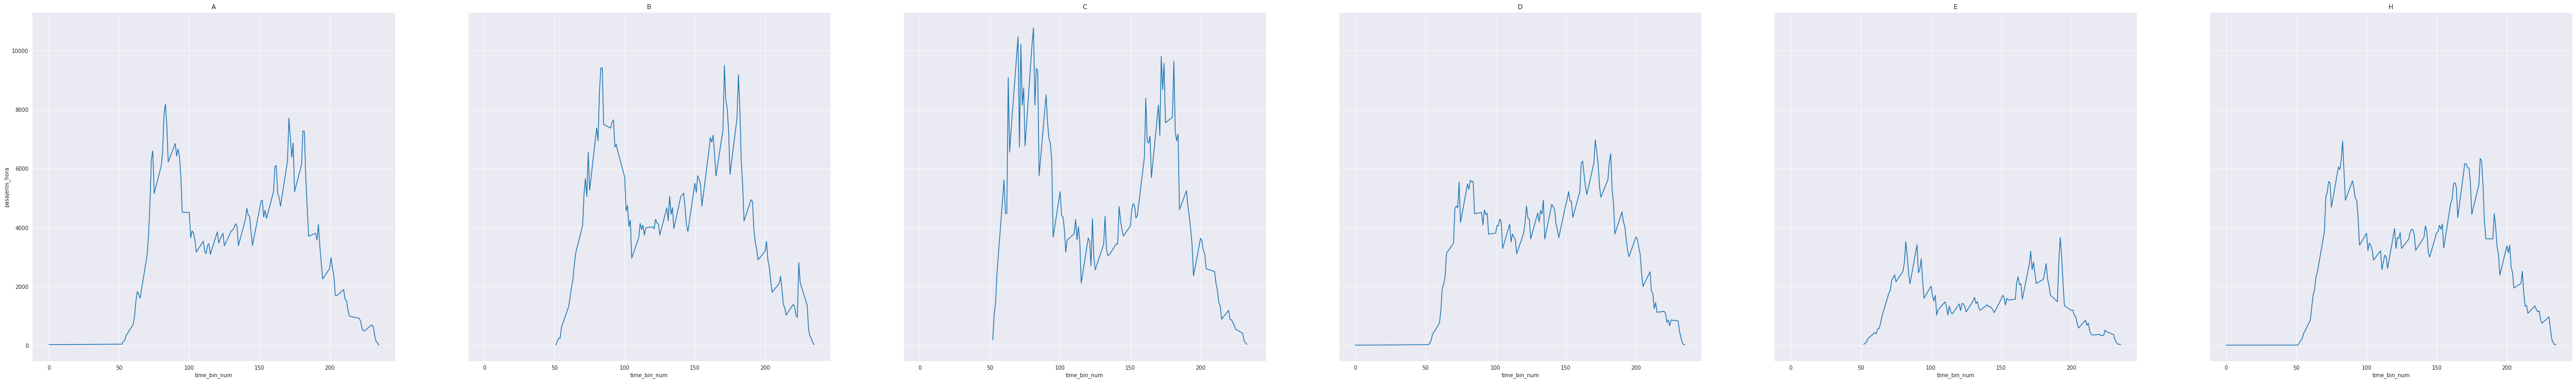

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
fig, axes = plt.subplots(ncols=6, sharex=True,sharey=True, figsize=(85,12))
lineas = ['A','B','C','D','E','H']
for ind in range(6):
  sns.lineplot(data=maximas_cargas[maximas_cargas.Linea == lineas[ind]], x='time_bin_num', y='pasajeros_hora', ax=axes[ind])
  axes[ind].set_title(lineas[ind])

In [ ]:
import plotly.express as px
linea = 'C'
fig = px.line(maximas_cargas[maximas_cargas.Linea == linea], x='time_bin_num', y='pasajeros_hora', hover_data=['tramos'], title='Pasajeros por hora - Linea '+linea)
# fig.suptitle('Línea ' + linea)
fig.show()

## Otros resultados

In [ ]:
pd.DataFrame(cargadf.tramos.unique().tolist()).to_excel("tramos.xlsx")

In [ ]:
# pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False, sort=True)[source]
(pd.pivot_table(cargadf, values="pasajeros", columns="time_bin_num", index="tramos", aggfunc="sum").fillna(0) * 6).to_excel("tramos_y_cargas_por_hora.xlsx")


In [ ]:
df[(df.Estacion == "Constitucion        ") & (df.Hora.apply(lambda hora: hora.hour * 10 + hora.minute).astype(int) < 60)]

,Linea,Estacion,Fecha,Hora,id,nombre_completo,estac_y_combins,fichada_repetida,time_bins


#TO DO
Resolver OCUPACION MAXIMA